In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import os
import torch
from tqdm import tqdm

pd.set_option('display.max_colwidth', None)

# 1,000 단위 표기
pd.options.display.float_format = '{:,.5f}'.format

# Unicode warning 제거 (폰트 관련 경고메시지)
plt.rcParams['axes.unicode_minus']=False

# 그래프 출력 사이즈 설정
plt.rcParams["figure.figsize"] = (10, 6)

# 경고 무시
warnings.filterwarnings('ignore')

# Data 경로 설정
DATA_DIR = 'data'

# 시드설정
SEED = 123

def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

%matplotlib inline

In [31]:
import FinanceDataReader as fdr

df = fdr.DataReader('BTC/USD')
df = df.drop('Adj Close', axis=1)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.86401,468.17401,452.42200,457.33402,21056800
2014-09-18,456.85998,456.85998,413.10400,424.44000,34483200
2014-09-19,424.10300,427.83499,384.53201,394.79599,37919700
2014-09-20,394.67300,423.29599,389.88300,408.90399,36863600
2014-09-21,408.08499,412.42600,393.18100,398.82101,26580100


In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
series = scaler.fit_transform(df)
series[:5]

array([[4.28907290e-03, 3.73944128e-03, 4.24270741e-03, 4.14358659e-03,
        4.31449241e-05],
       [4.15542811e-03, 3.57446063e-03, 3.64887469e-03, 3.65546320e-03,
        8.14009147e-05],
       [3.66922344e-03, 3.15121937e-03, 3.21734240e-03, 3.21556748e-03,
        9.11925723e-05],
       [3.23240062e-03, 3.08503185e-03, 3.29816008e-03, 3.42492004e-03,
        8.81834148e-05],
       [3.43147175e-03, 2.92652603e-03, 3.34797093e-03, 3.27529593e-03,
        5.88825241e-05]])

In [33]:
series_df = pd.DataFrame(series, index=df.index, columns=df.columns)
series_df

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,0.00429,0.00374,0.00424,0.00414,0.00004
2014-09-18,0.00416,0.00357,0.00365,0.00366,0.00008
2014-09-19,0.00367,0.00315,0.00322,0.00322,0.00009
2014-09-20,0.00323,0.00309,0.00330,0.00342,0.00009
2014-09-21,0.00343,0.00293,0.00335,0.00328,0.00006
...,...,...,...,...,...
2023-06-29,0.44394,0.44598,0.45137,0.44914,0.03754
2023-06-30,0.44921,0.45270,0.44447,0.44962,0.07517
2023-07-01,0.44966,0.44372,0.45548,0.45129,0.02587


## Windowed Dataset

In [56]:
N_PREDICTIONS = 1
N_FEATURES = 4
WINDOW_SIZE = 10

In [35]:
def make_dataset(series, target, window_size=WINDOW_SIZE, n_predictions=N_PREDICTIONS):
    Xs = []
    Ys = []
    for i in range(len(series) - window_size - n_predictions +1):
        Xs.append(series.iloc[i:i+window_size].drop(target, axis=1))
        Ys.append(series.iloc[i+window_size: i+window_size+n_predictions].loc[:, target])
    return np.array(Xs), np.array(Ys)

In [36]:
# 데이터셋 생성
Xs, Ys = make_dataset(series_df, 'Close')
Xs.shape, Ys.shape

((3202, 10, 4), (3202, 1))

In [37]:
n_splits = 200

x_train, y_train = Xs[:-n_splits], Ys[:-n_splits]
x_valid, y_valid = Xs[-n_splits:], Ys[-n_splits:]

In [38]:
x_train.shape, y_train.shape

((3002, 10, 4), (3002, 1))

In [39]:
x_valid.shape, y_valid.shape

((200, 10, 4), (200, 1))

In [40]:
series_df[-10:]

,Open,High,Low,Close,Volume
Date,,,,,
2023-06-24,0.45318,0.44610,0.45489,0.45068,0.03460
2023-06-25,0.45075,0.44956,0.45546,0.44966,0.03618
2023-06-26,0.44979,0.44365,0.44984,0.44656,0.04698
2023-06-27,0.44673,0.44905,0.45408,0.45275,0.04679
2023-06-28,0.45300,0.44463,0.44933,0.44382,0.04150
2023-06-29,0.44394,0.44598,0.45137,0.44914,0.03754
2023-06-30,0.44921,0.45270,0.44447,0.44962,0.07517
2023-07-01,0.44966,0.44372,0.45548,0.45129,0.02587
2023-07-02,0.45137,0.44554,0.45450,0.45175,0.03000


In [44]:
x_valid[-1]

array([[0.4411197 , 0.4546335 , 0.44817184, 0.06869591],
       [0.45317731, 0.44609736, 0.45489179, 0.03459607],
       [0.45074921, 0.44955508, 0.45546264, 0.03617927],
       [0.44978997, 0.44364585, 0.4498412 , 0.04697737],
       [0.44672934, 0.44905223, 0.45408382, 0.04679399],
       [0.45299656, 0.44462649, 0.44932886, 0.04150189],
       [0.44393693, 0.44598218, 0.45137357, 0.03753952],
       [0.44920858, 0.45269883, 0.44447243, 0.07516879],
       [0.4496612 , 0.44372255, 0.45547657, 0.02587372],
       [0.45137438, 0.44554313, 0.45449718, 0.02999613]])

In [45]:
y_valid[-1]

array([0.45767191])

## Tensor DataSet 생성

In [46]:
def make_tensor(x, device):
    return torch.FloatTensor(x).to(device)

In [47]:
# device 설정 (cuda 혹은 cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [48]:
x_train = make_tensor(x_train, device=device)
y_train = make_tensor(y_train, device=device)
x_valid = make_tensor(x_valid, device=device)
y_valid = make_tensor(y_valid, device=device)

In [49]:
train_ds = torch.utils.data.TensorDataset(x_train, y_train)
valid_ds = torch.utils.data.TensorDataset(x_valid, y_valid)

## DataLoader 생성

In [50]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_ds, 
                                           batch_size=batch_size, 
                                           shuffle=False)

valid_loader = torch.utils.data.DataLoader(dataset=valid_ds, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [51]:
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)

In [52]:
x.shape

torch.Size([32, 10, 4])

## Conv1d

![](https://i.stack.imgur.com/NmYZJ.png)

In [53]:
import torch.nn as nn

conv1 = nn.Conv1d(in_channels=WINDOW_SIZE, out_channels=50, kernel_size=3, padding='same', device=device)
conv_out = conv1(x)
conv_out.shape

torch.Size([32, 50, 4])

## 모델

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim

In [87]:
class BaseModel(nn.Module):
    def __init__(self, input_size, window_size, hidden_size, output_size, num_layers, bidirectional=True, drop_prob=0.1):
        super(BaseModel, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = 2 if bidirectional else 1
        
        self.conv = nn.Conv1d(in_channels=window_size, out_channels=64, kernel_size=3, padding='same', device=device)
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            bidirectional=bidirectional,
                            batch_first=True)
        
        self.dropout = nn.Dropout(drop_prob)
        
        self.fc = nn.Linear(hidden_size*self.bidirectional, output_size)
        
    def init_hidden_and_cell_state(self, batch_size, device):
        self.hidden_and_cell = (
            torch.zeros(self.num_layers*self.bidirectional, batch_size, self.hidden_size).to(device),
            torch.zeros(self.num_layers*self.bidirectional, batch_size, self.hidden_size).to(device),
        )
        
    def forward(self, x):
        x = self.conv(x)
        output, (h, c) = self.lstm(x, self.hidden_and_cell)
        h = output[:, -1, :]
        o = self.dropout(h)
        o = self.fc(o)
        return o

In [88]:
config = {
    'input_size': N_FEATURES,
    'window_size': WINDOW_SIZE,
    'hidden_size': 64, 
    'num_layers': 2, 
    'bidirectional': True,
    'output_size': N_PREDICTIONS, 
    
}

model = BaseModel(**config)

In [89]:
x, y = next(iter(train_loader))
x.to(device), y.to(device)

model = model.to(device)
model.init_hidden_and_cell_state(batch_size, device)
output = model(x)

In [90]:
output.shape

torch.Size([32, 1])

## 손실함수 & 옵티마이저 정의

In [91]:
model = model.to(device)
loss_fn = nn.HuberLoss()

lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

## 모델 훈련

In [92]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    
    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
#     prograss_bar = tqdm(data_loader, unit='batch', total=len(data_loader), mininterval=1)
    
    # mini-batch 학습을 시작합니다.
    for idx, (xs, ys) in enumerate(data_loader):
        # txt, lbl 데이터를 device 에 올립니다. (cuda:0 혹은 cpu)
        xs = xs.to(device)
        ys = ys.to(device)
        
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()
        
        # LSTM Weight 초기화
        model.init_hidden_and_cell_state(len(xs), device)
        
        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(xs)
        
        # 손실함수에 output, lbl 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, ys)
        
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()
        
        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()
        
        # batch 별 loss 계산하여 누적합을 구합니다.
        running_loss += loss.item()
        
        # 프로그레스바에 학습 상황 업데이트
#         prograss_bar.set_description(f"training loss: {running_loss/(idx+1):.5f}")
        
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss
    return running_loss / len(data_loader)

In [93]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        
        # 배치별 evaluation을 진행합니다.
        for xs, ys in data_loader:
            # txt, lbl 데이터를 device 에 올립니다. (cuda:0 혹은 cpu)
            xs = xs.to(device)
            ys = ys.to(device)
            
            # LSTM Weight 초기화
            model.init_hidden_and_cell_state(len(xs), device)
    
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(xs)
            
            # 검증 손실을 구합니다.
            loss = loss_fn(output, ys)
            
            # batch 별 loss 계산하여 누적합을 구합니다.
            running_loss += loss.item()
        
        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader)

In [94]:
# 최대 Epoch을 지정합니다.
num_epochs = 500

# checkpoint로 저장할 모델의 이름을 정의 합니다.
model_name = 'TimeSeries-LSTM-Conv1d'

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실을 반환 받습니다.
    train_loss = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실을 반환 받습니다.
    val_loss = model_evaluate(model, valid_loader, loss_fn, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{model_name}.pth')
    
    # Epoch 별 결과를 출력합니다.
    if epoch % 100 == 0:
        print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, val_loss: {val_loss:.5f}')

[INFO] val_loss has been improved from inf to 0.00223. Saving Model!
epoch 01, loss: 0.02294, val_loss: 0.00223
[INFO] val_loss has been improved from 0.00223 to 0.00223. Saving Model!
[INFO] val_loss has been improved from 0.00223 to 0.00158. Saving Model!
[INFO] val_loss has been improved from 0.00158 to 0.00125. Saving Model!
[INFO] val_loss has been improved from 0.00125 to 0.00074. Saving Model!
[INFO] val_loss has been improved from 0.00074 to 0.00065. Saving Model!
[INFO] val_loss has been improved from 0.00065 to 0.00064. Saving Model!
[INFO] val_loss has been improved from 0.00064 to 0.00052. Saving Model!
[INFO] val_loss has been improved from 0.00052 to 0.00044. Saving Model!
[INFO] val_loss has been improved from 0.00044 to 0.00031. Saving Model!
[INFO] val_loss has been improved from 0.00031 to 0.00029. Saving Model!
[INFO] val_loss has been improved from 0.00029 to 0.00024. Saving Model!
[INFO] val_loss has been improved from 0.00024 to 0.00022. Saving Model!
[INFO] val_l

## 저장한 가중치 로드

In [98]:
model.load_state_dict(torch.load(f'{model_name}.pth'))

<All keys matched successfully>

## Evaluation

In [99]:
model.eval()

results = []

with torch.no_grad():
    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        model.init_hidden_and_cell_state(len(x), device)
        output = model(x)
        results.extend(output.detach().cpu().numpy().flatten().tolist())
        
len(results)

200

## 예측 결과 시각화

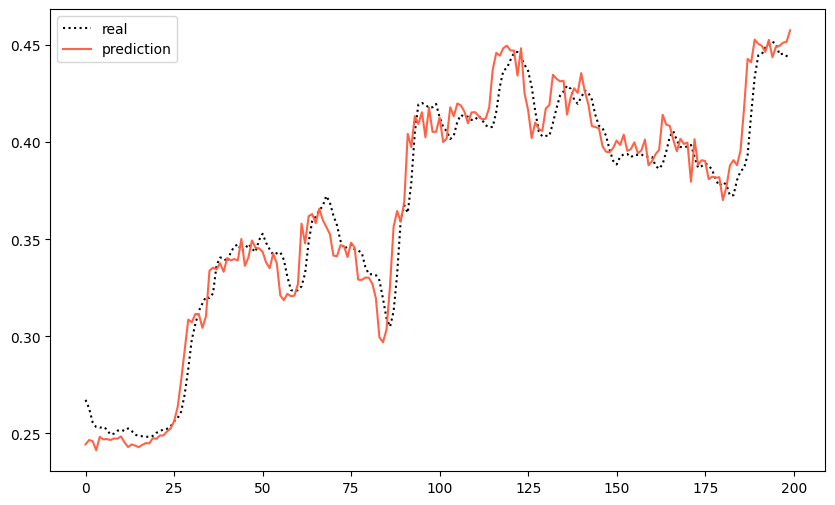

In [101]:
fig, ax = plt.subplots(1, 1)
ax.plot(results, color='black', linestyle='dotted', label='real')
ax.plot(y_valid.detach().cpu().numpy().flatten(), color='tomato', label='prediction')
plt.legend()
plt.show()